![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings/2.2.Spark_OCR_training_Table_recognition.ipynb)


# Spark-ocr demo for table recognition and free text extraction

The aim of this notebook is to show Spark-OCR abilities for 
* Table recognition
* Free-text extraction

## Set up environment

In [ ]:
# NBVAL_SKIP
import json, os
from google.colab import files

with open('spark_ocr_training.json') as f:
  license_keys = json.load(f)

#Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# NBVAL_SKIP
%pip install spark-nlp==3.4.0
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

**Attention!**

After everything is installed we restart runtime.


In [ ]:
#import os
#os.kill(os.getpid(), 9)

In [ ]:
# NBVAL_SKIP
!gdown 1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS

In [1]:
SPARK_OCR_SECRET = ""

## Run Spark-ocr

In [ ]:
# NBVAL_SKIP
import json

with open('spark_ocr_training.json') as f:
  license_keys = json.load(f)

#Defining license key-value pairs as local variables
#locals().update(license_keys)
for k, v in license_keys.items():
  os.environ[k] = v

In [2]:
from pyspark import SparkConf
from sparkocr import start

# Start spark
spark_ocr_jar_path = "../../../target/scala-2.12/"
spark = start(secret=SPARK_OCR_SECRET, jar_path=spark_ocr_jar_path)

Spark version: 3.2.1
Spark NLP version: 5.2.0
Spark NLP for Healthcare version: 5.2.0
Spark OCR version: 5.1.0



### Load sample

In [3]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables
from pyspark.ml import PipelineModel

# Note: Colab Path could be different!
imagePath = "./data/cTDaR_t10096.jpg"

df = spark.read.format("binaryFile").load(imagePath)
df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/Users/nmeln...|2023-07-04 08:07:13|385071|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+




### What if no table recognition?

In [4]:
binary_to_image = BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

ocr = ImageToText()
ocr.setInputCol("image")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setOutputSpaceCharacterWidth(10)

pipeline_ocr = PipelineModel(stages=[
    binary_to_image,
    ocr
])

result = pipeline_ocr.transform(df).cache()
print("\n".join([row.text for row in result.select("text").collect()]))

 

HISTORY, DEVELOPMENT AND CORPORATE STRUCTURE

 

(iii) Series B Financing

On April 28, 2018, the Company and its subsidiaries entered into the Series B Share
Purchase Agreement with the then Series B Preferred Shareholders, pursuant to which the then
Series B Preferred Shareholders agreed to subscribe for a maximum of 45,908,818 Series B
Preferred Shares in aggregate to be issued by our Company at a subscription price of
approximately US$5.66 per share and an aggregate consideration of approximately US$260
million. The Series B Preferred Shares were issued in full on May 8, 2018 as set forth in the
table below.

 

 

Number of
Series B            Purchase
Name of Shareholder                         Preferred Shares            Amount
(US$)
WuXi Healthcare Ventures                              882,861        4,999,994.99
6 Dimensions Capital, L.P.                             3,354,875       18,999,999.08
6 Dimensions Affiliates Fund, L.P.                       176,572         999,99


### Table data extraction

In [5]:
binary_to_image = BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

# Detect tables on the page using pretrained model
# It can be finetuned for have more accurate results for more specific documents
table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

# Draw detected region's with table to the page
draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("region")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(Color.red)

# Extract table regions to separate images
splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")

# Detect cells on the table image
cell_detector = ImageTableCellDetector()
cell_detector.setInputCol("table_image")
cell_detector.setOutputCol("cells")
cell_detector.setAlgoType("morphops")
cell_detector.setDrawDetectedLines(True)

# Extract text from the detected cells 
table_recognition = ImageCellsToTextTable()
table_recognition.setInputCol("table_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(3)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

# Erase detected table regions
fill_regions = ImageDrawRegions()
fill_regions.setInputCol("image")
fill_regions.setInputRegionsCol("region")
fill_regions.setOutputCol("image_1")
fill_regions.setRectColor(Color.white)
fill_regions.setFilledRect(True)

# OCR
ocr = ImageToText()
ocr.setInputCol("image_1")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setKeepLayout(True)
ocr.setOutputSpaceCharacterWidth(8)

pipeline_table = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results = pipeline_table.transform(df).cache()

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


In [6]:
tables_results.show()

+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+-----------------+---------+--------------------+--------------------+
|         table_image|              region|               image|   modificationTime|             image_1|                path|length|pagenum|  image_with_regions|               cells|        output_image|               table|       confidence|exception|                text|           positions|
+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+-----------------+---------+--------------------+--------------------+
|{file:/Users/nmel...|{0, 0, 214.0, 437...|{file:/Users/nmel...|2023-07-04 08:07:13|{file:/Users/nmel...|file:/U


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/tutorials/Certification_Trainings/data/cTDaR_t10096.jpg
    Resolution: 0 dpi
    Width: 1190 px
    Height: 1588 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


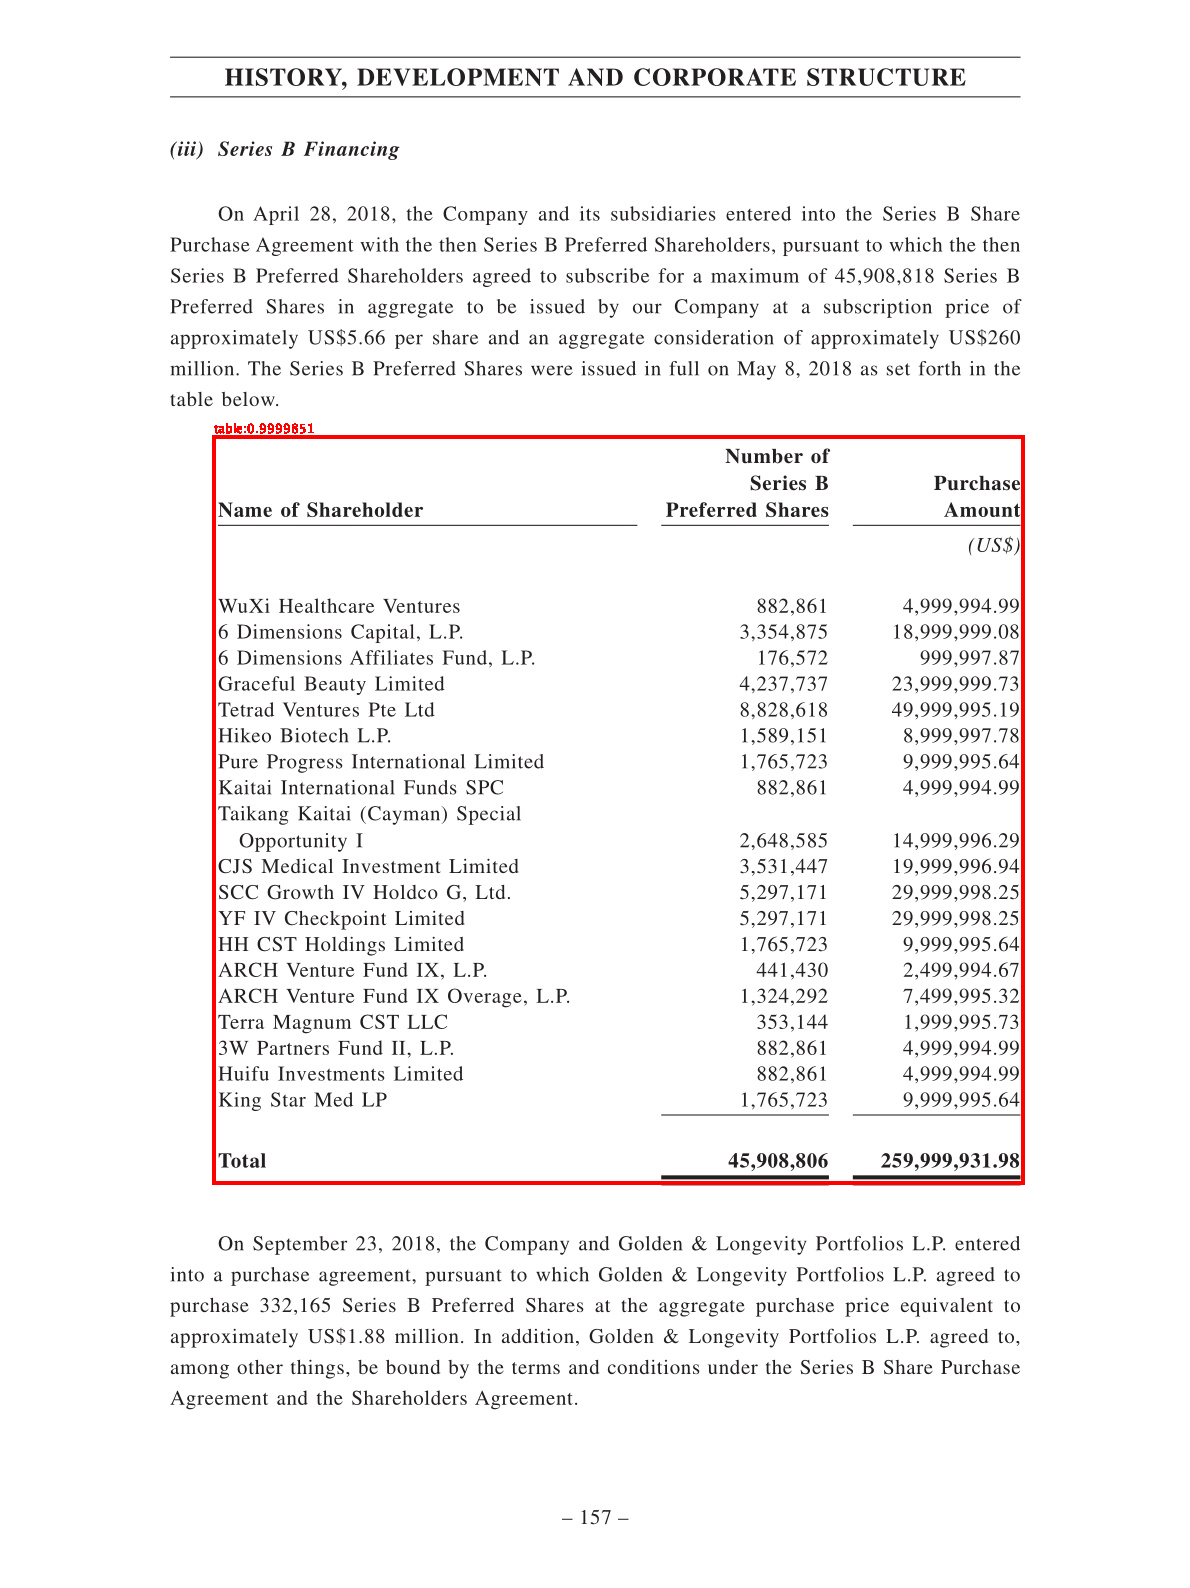

In [7]:
display_images(tables_results, "image_with_regions")

## Tables

In [8]:
display_tables(tables_results)

Filename: cTDaR_t10096.jpg
Page: 0
Table: 0
Number of Columns: 3


col0,col1,col2
Empty,Number of,Empty
Empty,Series B,Purchase
Name of Shareholder,Preferred Shares,Amount
Empty,Empty,(US$)
WuXi Healthcare Ventures,882. 861,4.999 .994.99
"6 Dimensions Capital, L.P.",9 354-875,"18,.999.999.08"
"6 Dimensions Affiliates Fund, L.P.",176.572,999.997.87
Graceful Beauty Limited,4.937.737,23.999.999.73
Tetrad Ventures Pte Ltd,8.828.618,49.999 995.19
Hikeo Biotech L.P.,"1,589,151","8,999.997.78"


## Free text

In [9]:
tables_results.select("text").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Processing of PDF


In [ ]:
!gdown 1AhAKlyxX_PEWI9bI0M0KH0wgzrKOpLTt

In [10]:
pdfPath = "./data/budget.pdf"

pdf_df = spark.read.format("binaryFile").load(pdfPath)

pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setKeepInput(True)

pipeline_table_pdf = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results_pdf = pipeline_table_pdf.transform(pdf_df).cache()

In [ ]:
%%time
display_images(tables_results_pdf, "image_with_regions")

Table extracted from pdf

In [ ]:
display_tables(tables_results_pdf)